This notebook is for plotting snapshots plots corresponding to high and low NAO events. In particular, maps of anomlaies in wind stress, heat flux, SST, mixed-layer depth etc. are plotted.

In [1]:
# Load libraries

import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=9, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', orien='vertical', colorbar=True,
            y_lab = True, x_lab = True, grid_line = True):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                         transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    if(colorbar==True):
        cb = plt.colorbar(p, ax=ax, extend='both', shrink=1.0, orientation=orien)
        cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    if(grid_line == True):
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1., color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    gl.ylocator = mticker.FixedLocator([70, 60, 50, 40, 30])
    gl.xlocator = mticker.FixedLocator([-80, -60, -40, -20, 0])
    
    if(y_lab==False):
        gl.ylocator = mticker.FixedLocator([])
    if(x_lab==False):
        gl.xlocator = mticker.FixedLocator([])
    
    ax.add_feature(cfeature.LAND) #facecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=12)
    return p

In [4]:
# Read data for NAO and compute seasonal values

ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly_new.nc")

#NAO_season = ds_NAO['NAO'].copy()
NAO_season = (ds_NAO['P_south'] - ds_NAO['P_north']) # for NAO indices in pa

tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg

%time NAO_season = NAO_season.resample(time='QS-DEC').mean('time').compute()

CPU times: user 35.3 ms, sys: 1.54 ms, total: 36.8 ms
Wall time: 40.3 ms


In [5]:
NAO_cut = 1300. # in hpa (for normalised NAO indices, use 2.5 cut-off to be consistent with other scripts)

count_NAOp = 0
count_NAOn = 0

for ind in range(4,13,4):
    
    c_NAOp = (xr.where(NAO_season.isel(time=ind) >= NAO_cut, 1, 0)).sum().values
    c_NAOn = (xr.where(NAO_season.isel(time=ind) <= -NAO_cut, 1, 0)).sum().values
    
    count_NAOp =  count_NAOp + c_NAOp
    count_NAOn =  count_NAOn + c_NAOn
    
    print('NAOp = ',c_NAOp, ', NAOn = ', c_NAOn) 

print('Total NAO positive members = ', count_NAOp)
print('Total NAO negative members = ', count_NAOn)

NAOp =  34 , NAOn =  49
NAOp =  39 , NAOn =  44
NAOp =  41 , NAOn =  40
Total NAO positive members =  114
Total NAO negative members =  133


In [6]:
# Read surface anomly data (old data using normalised NAO indices)

"""
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Composite/time_series/NAO/"

ds_NAOp = []
ds_NAOn = []
tauu_NAOp = []
tauu_NAOn = []

NAO_shifted = []

var_list = ['tos', 'hfds', 'mlotst']
var_list_atmos = ['tauu']

NAO_cut = 2.5

count_NAOp = 0
count_NAOn = 0

for ind in range(4,13,4):
    
    c_NAOp = (xr.where(NAO_season.isel(time=ind) >= NAO_cut, 1, 0)).sum().values
    c_NAOn = (xr.where(NAO_season.isel(time=ind) <= -NAO_cut, 1, 0)).sum().values
    
    count_NAOp =  count_NAOp + c_NAOp
    count_NAOn =  count_NAOn + c_NAOn
    
    d_NAOp = xr.open_mfdataset(ppdir + "*NAOp*ind_" + str(ind) + ".nc")
    d_NAOp = d_NAOp.get(var_list)
    d_NAOp = d_NAOp.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_NAOp
    
    tau_NAOp = xr.open_mfdataset(ppdir + "*NAOp_tauu*ind_" + str(ind) + ".nc")
    tau_NAOp = tau_NAOp.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_NAOp
    
    d_NAOn = xr.open_mfdataset(ppdir + "*NAOn*ind_" + str(ind) + ".nc")
    d_NAOn = d_NAOn.get(var_list)
    d_NAOn = d_NAOn.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_NAOn
    
    tau_NAOn = xr.open_mfdataset(ppdir + "*NAOn_tauu*ind_" + str(ind) + ".nc")
    tau_NAOn = tau_NAOn.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_NAOn
    
    if(ind > 4):
        d_NAOn = d_NAOn.drop('time')
        d_NAOp = d_NAOp.drop('time')
        tau_NAOn = tau_NAOn.drop('time')
        tau_NAOp = tau_NAOp.drop('time')
    
    ds_NAOp.append(d_NAOp)
    ds_NAOn.append(d_NAOn)
    tauu_NAOn.append(tau_NAOn)
    tauu_NAOp.append(tau_NAOp)
    
    #NAO_shifted = ds
    
    print('NAOp = ', c_NAOp, 'NAOn = ', c_NAOn)

ds_NAOp = sum(ds_NAOp)/count_NAOp
ds_NAOn = sum(ds_NAOn)/count_NAOn
tauu_NAOp = sum(tauu_NAOp)/count_NAOp
tauu_NAOn = sum(tauu_NAOn)/count_NAOn

"""

NAOp =  30 NAOn =  45
NAOp =  38 NAOn =  49
NAOp =  39 NAOn =  45


In [7]:
# Read data (using NAO indices in hpa)

ds_NAOp = []
ds_NAOn = []

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

var_list = ['mlotst', 'tos', 'tauu', 'Heat_Budget']

case_list = ['NAOp', 'NAOn']

for case in case_list:
    
    for var in var_list:
        
        d = xr.open_mfdataset(ppdir + "Composite_" + case + "_" + var + ".nc", chunks={'time':1})
        
        if(case == 'NAOp'):
            ds_NAOp.append(d)
        elif(case == 'NAOn'):
            ds_NAOn.append(d)
            
ds_NAOp = xr.merge(ds_NAOp)
ds_NAOn = xr.merge(ds_NAOn)

ds_NAOp = ds_NAOp.mean('comp')
ds_NAOn = ds_NAOn.mean('comp')

print(ds_NAOp)

<xarray.Dataset>
Dimensions:                          (j: 321, i: 361, time: 101, lat: 99,
                                      lon: 432)
Coordinates:
  * j                                (j) int32 780 781 782 ... 1098 1099 1100
  * i                                (i) int32 810 811 812 ... 1168 1169 1170
    latitude                         (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    longitude                        (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
  * lat                              (lat) float64 20.28 20.83 ... 74.17 74.72
  * lon                              (lon) float64 0.0 0.8333 ... 358.3 359.2
    nav_lat                          (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    nav_lon                          (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
Dimensions without coordinates: time
Data variables: (12/13)
    mlotst                           (time, j, i) float32 dask.arr

<Figure size 1296x288 with 0 Axes>

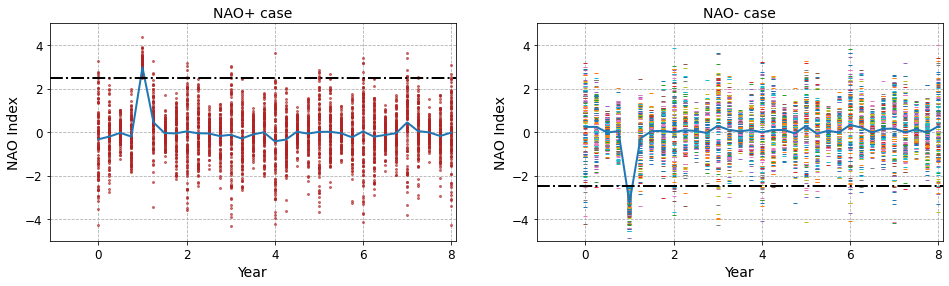

In [63]:
NAO_cut =2.5

fig = plt.figure(figsize=[18,4])

grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[16,4])

for i in range( 0,2):
    
    tmp_mean = []
    
    ax = fig.add_subplot(grid[0, i])
    
    if(i==0):
    
        for year in range(0,len(ds_NAO['start_year'])):

            for r in range(0,10):
                
                for ind in range(4,13,4):
                    
                    tmp = NAO_season.where((NAO_season.isel(time=ind) >= NAO_cut)).isel(start_year=year, r=r)
                    tmp = tmp.isel(time = slice((int(ind/4)-1)*4, (int(ind/4) + 7)*4 + 1))
                    
                    ax.plot(np.arange(0,len(tmp.time))/4 + year*0 - (ind*0 - 0)/4, tmp,
                            '.', ms=4, color='firebrick', alpha=0.6)
                    
                    tmp_mean.append(tmp.drop(['time', 'start_year']))
                    
        tmp_mean = xr.concat(tmp_mean, dim='case')
        ax.plot(np.arange(0,len(tmp_mean.time))/4, tmp_mean.mean('case'), lw=2)
                    
    elif(i==1):
        
        for year in range(0,len(ds_NAO['start_year'])):

            for r in range(0,10):
                
                for ind in range(4,13,4):
                    
                    tmp = NAO_season.where((NAO_season.isel(time=ind) <= -NAO_cut)).isel(start_year=year, r=r)
                    tmp = tmp.isel(time = slice((int(ind/4)-1)*4, (int(ind/4) + 7)*4 + 1))
                    
                    ax.plot(np.arange(0,len(tmp.time))/4 + year*0 - (ind*0 - 0)/4, tmp, '_', ms=4)#, color='slateblue', alpha=0.6)
                    
                    tmp_mean.append(tmp.drop(['time', 'start_year']))
                    
        tmp_mean = xr.concat(tmp_mean, dim='case')
        ax.plot(np.arange(0,len(tmp_mean.time))/4, tmp_mean.mean('case'), lw=2)

    ax.grid('on', ls='--')
    ax.set_ylabel('NAO Index',  fontsize=14)
    ax.set_xlabel('Year',  fontsize=14)
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    ax.set_ylim([-5., 5.])
    if(i==0):
        plt.title('NAO+ case', fontsize=14)
        ax.axhline(y=2.5, ls='-.', lw=2, color='k');
    if(i==1):
        plt.title('NAO- case', fontsize=14)
        ax.axhline(y=-2.5, ls='-.', lw=2, color='k');
        
    ax.set_xlim([-1.1, 8.1])

#### Figure 1

In figure 1, we plot sesonal timeseries of NAO indices for selected members (both NAO+ and NAO- cases). In addition, DJFM means of surface diagnostics are plotted to see immediate effect of NAO conditions.

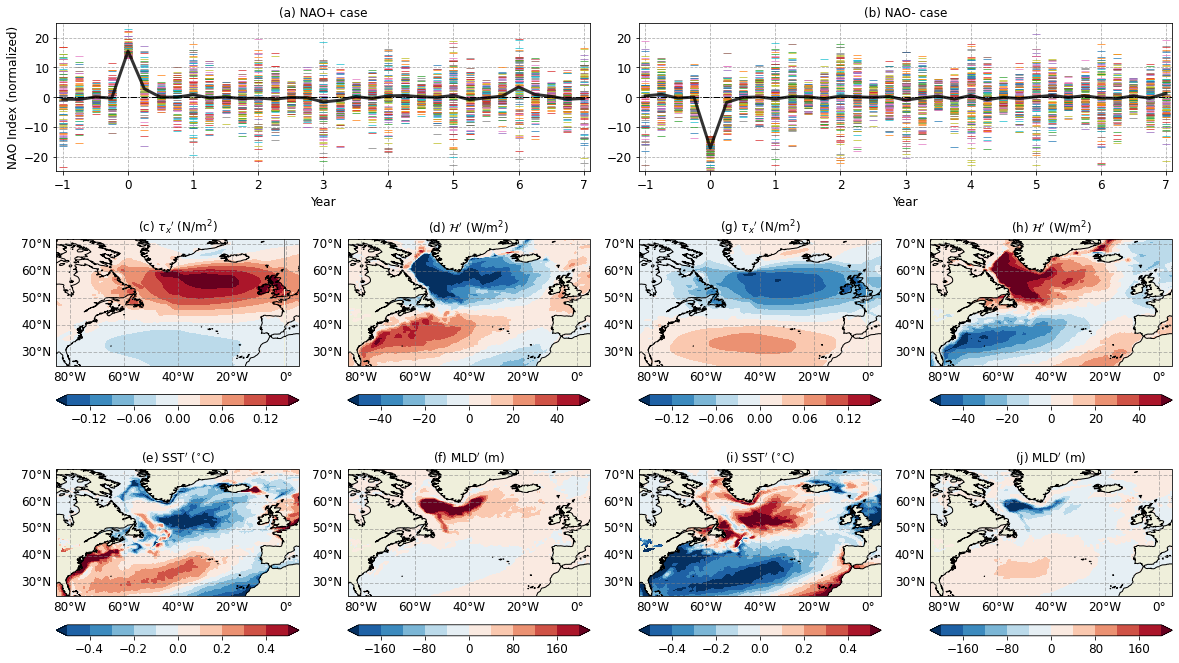

In [147]:
grid1 = plt.GridSpec(3, 4, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[20,12])

var_list = ['hfds', 'tos', 'mlotst'] #, 'tauu'] 
name = [r'${\tau_x}^{\prime}$ (N/m$^2$)', r'${\mathcal{H}}^{\prime}$ (W/m$^2$)', r'SST$^{\prime}$ ($^{\circ}$C)' , 'MLD$^{\prime}$ (m)']
val = [0.15, 50., 0.5, 200.]

lat_lon_ext = [-85., 5., 25., 72.]

case_list = ['NAOp', 'NAOn']
tim_ind =4

for case in case_list: 

    count = 1

    for var in var_list:

        titl = str(name[count])
        
        # get seasonl mean for the relavant data
        if (case == 'NAOp'):
            ax = fig.add_subplot(grid1[1 + int(count/2), count - int(count/2)*2], projection=ccrs.PlateCarree(),facecolor='grey')
            tmp = ds_NAOp[var].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+2+3)).mean('time')
            titl = '(' + chr(99+count) + ') ' + str(name[count])
        elif(case == 'NAOn'):
            ax = fig.add_subplot(grid1[1 + int(count/2), count - int(count/2)*2 + 2], projection=ccrs.PlateCarree(),facecolor='grey')
            tmp = ds_NAOn[var].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+2+3)).mean('time')
            titl = '(' + chr(103+count) + ') ' + str(name[count])
            
        p = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 11,
                     lon='longitude', lat='latitude', cmap='RdBu_r', title=titl, orien='horizontal')

        count = count + 1
        
    if (case == 'NAOp'):
        ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
        tmp = ds_NAOp['tauu'].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+2+3)).mean('time')
        titl = '(c) ' + str(name[0])
    elif(case == 'NAOn'):
        ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
        tmp = ds_NAOn['tauu'].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+2+3)).mean('time')
        titl = '(g) ' + str(name[0])

    p = plot_sec(ax, tmp, vmin=-val[0], vmax=val[0],  lat_lon_ext = lat_lon_ext, levels = 11,
                 lon='lon', lat='lat', cmap='RdBu_r', title=titl, orien='horizontal')
    

for i in range(0,2):
    
    tmp_mean = []
    
    ax = fig.add_subplot(grid1[0, (0+2*i):2*(i+1)])
    
    if(i==0):
    
        for year in range(0,len(ds_NAO['start_year'])):

            for r in range(0,10):
                    
                for ind in range(4,13,4):
                    
                    tmp = NAO_season.where((NAO_season.isel(time=ind) >= NAO_cut)).isel(start_year=year, r=r)
                    tmp = tmp.isel(time = slice((int(ind/4)-1)*4, (int(ind/4) + 7)*4 + 1)) / 100. # convert to hpa
                
                    ax.plot(np.arange(0,len(tmp.time))/4 - 1, tmp, '_', ms=8, alpha=0.7)
                    
                    #ax.plot(np.arange(0,len(NAO_season.time))/4 + year*0 - (ind - 4)/4, 
                    #        NAO_season.where((NAO_season.isel(time=ind) >= 
                    #                          NAO_cut)).isel(start_year=year, r=r), '_', ms=6, color='firebrick', alpha=0.7)
                    
                    tmp_mean.append(tmp.drop(['time', 'start_year']))
                    
        tmp_mean = xr.concat(tmp_mean, dim='case')
        ax.plot(np.arange(0,len(tmp_mean.time))/4 - 1, tmp_mean.mean('case'), lw=3, color='k', alpha=0.8)
                
    elif(i==1):
        
        for year in range(0,len(ds_NAO['start_year'])):

            for r in range(0,10):
                
                for ind in range(4,13,4):
                    
                    tmp = NAO_season.where((NAO_season.isel(time=ind) <= -NAO_cut)).isel(start_year=year, r=r)
                    tmp = tmp.isel(time = slice((int(ind/4)-1)*4, (int(ind/4) + 7)*4 + 1)) / 100. # convert to hpa
                
                    ax.plot(np.arange(0,len(tmp.time))/4 - 1, tmp, '_', ms=8, alpha=0.7) 
                    
                    #ax.plot(np.arange(0,len(NAO_season.time))/4 + year*0 - (ind - 4)/4, 
                    #        NAO_season.where((NAO_season.isel(time=ind) <= 
                    #                          -NAO_cut)).isel(start_year=year, r=r),'_', ms=6, color='slateblue', alpha=0.7)
                    
                    tmp_mean.append(tmp.drop(['time', 'start_year']))
                    
        tmp_mean = xr.concat(tmp_mean, dim='case')
        ax.plot(np.arange(0,len(tmp_mean.time))/4 - 1, tmp_mean.mean('case'), lw=3, color='k', alpha=0.8)

    ax.grid('on', ls='--')
    ax.set_xlabel('Year',  fontsize=12)
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    ax.set_ylim([-25., 25.])
    if(i==0):
        plt.title('(a) NAO+ case', fontsize=12)
        ax.axhline(y=0., ls='-.', lw=1., color='k');
        ax.set_ylabel('NAO Index (normalized)',  fontsize=12)
    if(i==1):
        plt.title('(b) NAO- case', fontsize=12)
        ax.axhline(y=-0., ls='-.', lw=1., color='k');
        
    ax.set_xlim([-1.1, 7.1])
    
    bbox=plt.gca().get_position()
    offset=.05
    plt.gca().set_position([bbox.x0 , bbox.y0 + offset*0.5, bbox.x1-bbox.x0 - offset*0.0, bbox.y1 - bbox.y0 - offset])
    
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure1.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure1.pdf', dpi=300,bbox_inches='tight');

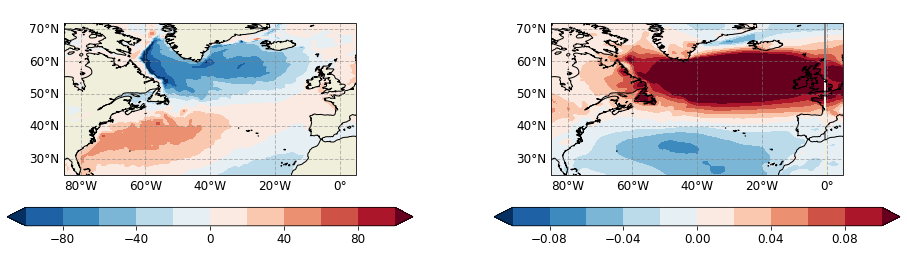

In [13]:
tmp = ds_NAOp['hfds'].isel(time=14).sel(j=slice(780, 1100),i=slice(810,1170))

grid1 = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[16,4])

lat_lon_ext = [-85., 5., 25., 72.]

ax = fig.add_subplot(grid1[0,0], projection=ccrs.PlateCarree(),facecolor='grey')

[p, cb] = plot_sec(ax, tmp, vmin=-100., vmax=100.,  lat_lon_ext = lat_lon_ext, levels = 11,
                        lon='longitude', lat='latitude', cmap='RdBu_r', title=' ', orien='horizontal')

tmp = tauu_NAOp['tauu'].isel(time=14).sel(lat=slice(20., 75.))

ax = fig.add_subplot(grid1[0,1], projection=ccrs.PlateCarree(),facecolor='grey')

[p, cb] = plot_sec(ax, tmp, vmin=-0.1, vmax=0.1,  lat_lon_ext = lat_lon_ext, levels = 11,
                 lon='lon', lat='lat', cmap='RdBu_r', title=' ', orien='horizontal')

In [12]:
print(1170-810, 1100-780)

360 320


#### Figure 2

In figure 2, time evolution of anomalies in upper ocean het content, surface heat flux, SST, MLD, and overturning (both in depth and sigma space) are plotted. This is to show the long-term impacts of NAO extremes.  

In [7]:
"""
# Old data from NAO normalised indices and only for r=0-4

data_dir = "/home/users/hkhatri/DePreSys4_Data/Data_Composite/time_series/NAO/Heat_Budget/"

ds_grid = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")

ds_mask = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Mask_UVT_grid.nc")

HB_NAOp = []
HB_NAOn = [] 

count_NAOp = 0
count_NAOn = 0

for ind in range(4,13,4):
    
    c_NAOp = (xr.where(NAO_season.isel(time=ind) >= NAO_cut, 1, 0)).sum().values
    c_NAOn = (xr.where(NAO_season.isel(time=ind) <= -NAO_cut, 1, 0)).sum().values
    
    count_NAOp =  count_NAOp + c_NAOp
    count_NAOn =  count_NAOn + c_NAOn
    
    d = xr.open_dataset(data_dir + "Composite_NAOp_Heat_Budget_tim_ind_" + str(ind) + ".nc", chunks={'time':1})
                        
    d = (d.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)) * c_NAOp).drop('time')
    
    HB_NAOp.append(d)
    
    d = xr.open_dataset(data_dir + "Composite_NAOn_Heat_Budget_tim_ind_" + str(ind) + ".nc", chunks={'time':1})
                       
    d = (d.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)) * c_NAOn).drop('time')
    
    HB_NAOn.append(d)
    
HB_NAOp = xr.concat(HB_NAOp, dim="comp")
HB_NAOn = xr.concat(HB_NAOn, dim="comp")

HB_NAOp = HB_NAOp.sum('comp') / count_NAOp
HB_NAOn = HB_NAOn.sum('comp') / count_NAOn

HB_NAOp = xr.merge([HB_NAOp, ds_grid['area_t'].rename({'y':'j', 'x':'i'}), ds_mask.drop(['nav_lat', 'nav_lon'])])
HB_NAOp = HB_NAOp.assign(time = ds_NAO['time_val'].isel(start_year=0, time = slice((int(4/4)-1)*12, (int(4/4) + 7)*12 + 5))).drop('start_year')

HB_NAOn = xr.merge([HB_NAOn, ds_grid['area_t'].rename({'y':'j', 'x':'i'}), ds_mask.drop(['nav_lat', 'nav_lon'])])
HB_NAOn = ds_NAOn.assign(time = ds_NAO['time_val'].isel(start_year=0, time = slice((int(4/4)-1)*12, (int(4/4) + 7)*12 + 5))).drop('start_year')

"""

In [13]:
%time tmp_ds = ds_NAOp.compute()

tmp_ds = tmp_ds.assign(time = ds_NAO['time_val'].isel(start_year=0, time = slice((int(4/4)-1)*12, (int(4/4) + 7)*12 + 5))).drop('start_year')

CPU times: user 25.4 s, sys: 31.5 s, total: 56.9 s
Wall time: 5min 52s


In [39]:
ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

ds_psi = xr.open_dataset(ppdir + "Composite_NAOp_Overturning.nc", chunks={'time':1})

%time ds_psi = ds_psi.mean('comp').compute()

CPU times: user 15.7 s, sys: 16.1 s, total: 31.8 s
Wall time: 7min 27s


In [50]:
tmp = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Temp/Overturning_Heat_Transport_r1.nc", chunks={'start_year':1})
lat = tmp['latitude'].isel(start_year=0)

ds_psi = ds_psi.drop('latitude')
ds_psi['latitude'] = lat

print(ds_psi)

<xarray.Dataset>
Dimensions:                (time: 101, lev: 75, j_c: 450, sigma0: 48, lat: 153)
Coordinates:
  * j_c                    (j_c) int32 699 700 701 702 ... 1145 1146 1147 1148
  * lev                    (lev) float64 0.5058 1.556 ... 5.698e+03 5.902e+03
  * sigma0                 (sigma0) float64 16.0 18.0 19.5 ... 28.9 29.5 30.5
  * lat                    (lat) float64 0.2778 0.8333 1.389 ... 84.17 84.72
    start_year             int64 1960
Dimensions without coordinates: time
Data variables:
    Overturning_z          (time, lev, j_c) float32 3.022e+04 -2.777e+04 ... 0.0
    Overturning_sigma      (time, j_c, sigma0) float32 -3.165e+03 ... 265.5
    MHT_sigma              (time, j_c, sigma0) float32 -3.666e+11 ... 0.0
    MHT_overturning_sigma  (time, j_c, sigma0) float32 -5.018e+09 ... 0.0
    MHT_z                  (time, lev, j_c) float32 -6.228e+11 ... 0.0
    MHT_overturning_z      (time, lev, j_c) float32 -6.417e+11 ... 0.0
    Overturning_Ekman      (time, lat) f

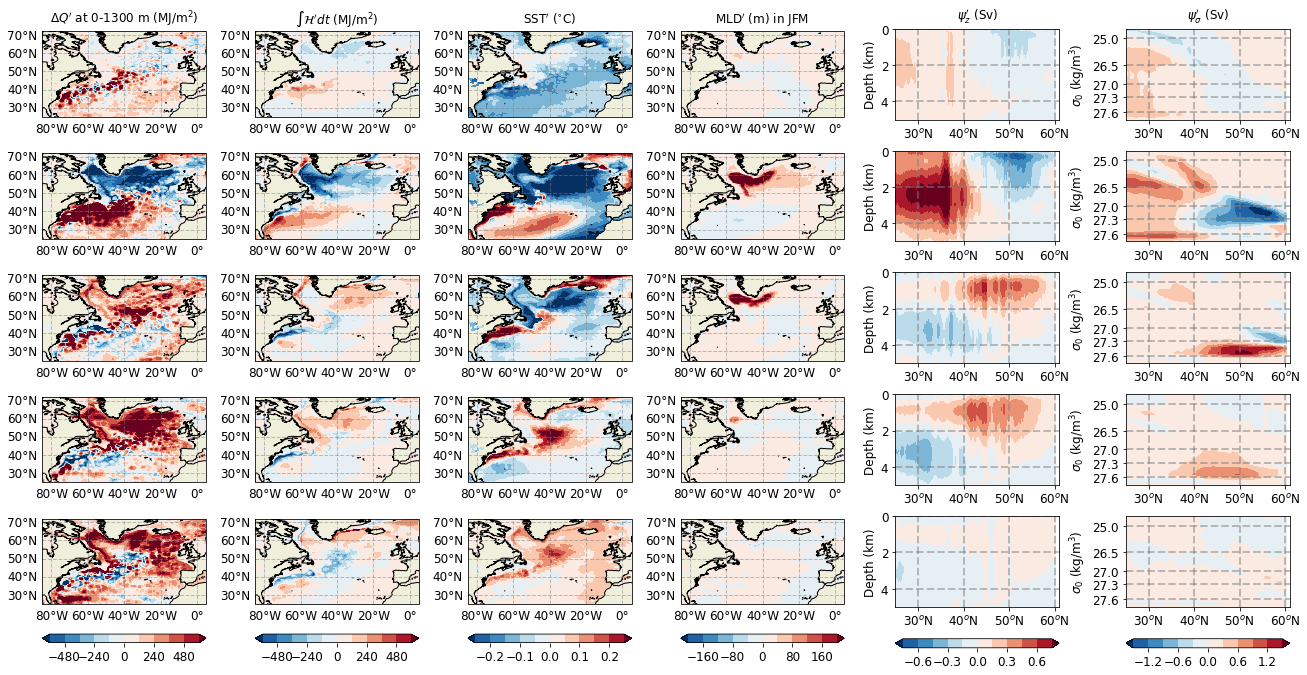

In [148]:
# Plot heat content anomalies with 12-month moving average for NAO+ case

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-85., 5., 25., 72.]

grid1 = plt.GridSpec(5, 6, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[22,11])

#tmp_ds = xr.merge([HB_NAOp, ds_NAOp.get(['tos','mlotst'])])

name = [r'$\Delta Q^{\prime}$ at 0-1300 m (MJ/m$^2$)', r'$\int {\mathcal{H}}^{\prime} dt$ (MJ/m$^2$)', 
        r'SST$^{\prime}$ ($^{\circ}$C)' , 'MLD$^{\prime}$ (m) in JFM', r'$\psi_z^{\prime}$ (Sv)', r'$\psi_{\sigma}^{\prime}$ (Sv)']

ax1 = [] 

for i in range(0,5):
    
    tmp1 = tmp_ds['Heat_Content_200'] + tmp_ds['Heat_Content_1300']
    
    if (i<=2):
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*i + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    elif (i==3):
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+1) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*(i+1) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    else:
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+2) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*(i+2) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
                    
    tmp = tmp.where(tmp_ds['tos'].isel(time=0) < 100.) # mask 0s on land
    
    if(i==4):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-600., vmax=600.,  lat_lon_ext = lat_lon_ext, levels = 11,
                 lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=titl, orien='horizontal',
                colorbar=False, y_lab = True, x_lab = True)
    
    ax1.append(ax)

axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

for i in range(0,5):
    
    tmp1 = tmp_ds['hfds']
    
    if (i<=2):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).sum('time')) * 30. * 24 * 3600. / 1e6
    elif (i==3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+1) + 2 + 3)).sum('time')) * 30. * 24 * 3600. / 1e6
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+2) + 2 + 3)).sum('time')) * 30. * 24 * 3600. / 1e6
    
    if(i==4):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[1])
    else: 
        titl = ' '
    
    tmp = tmp.where(tmp_ds['tos'].isel(time=0) <100.)
    
    ax = fig.add_subplot(grid1[i, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-600., vmax=600.,  lat_lon_ext = lat_lon_ext, levels = 11,
                lon='longitude', lat='latitude', cmap='RdBu_r', title=titl,  
                orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)
    
for i in range(0,5):
    
    tmp1 = tmp_ds['tos']
    
    if (i<=2):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1)) # anomaly from Dec (2nd month)
    elif (i==3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+1) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1)) # anomaly from Dec (2nd month)
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+2) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1)) # anomaly from Dec (2nd month)
    
    if(i==4):
        xlab = True
    else:
        xlab = False 
    
    if(i==0):
        titl = str(name[2])
    else: 
        titl = ' '
        
    ax = fig.add_subplot(grid1[i, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-0.25, vmax=0.25,  lat_lon_ext = lat_lon_ext, levels = 11,
                lon='longitude', lat='latitude', cmap='RdBu_r', title=titl,  
                orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

for i in range(0,5):
    
    tmp1 = tmp_ds['mlotst']
    
    if (i<=2):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 3)).mean('time')) 
    elif (i==3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+1) + 2 + 3)).where(tmp1['time.month']<=3).mean('time'))
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+2) + 2 + 3)).where(tmp1['time.month']<=3).mean('time'))
    
    if(i==4):
        xlab = True
    else:
        xlab = False
        
    if(i==0):
        titl = str(name[3])
    else: 
        titl = ' '
        
    ax = fig.add_subplot(grid1[i, 3], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-200., vmax=200.,  lat_lon_ext = lat_lon_ext, levels = 11,
                lon='longitude', lat='latitude', cmap='RdBu_r', title=titl,  
                orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)


for i in range(0,5):
    
    tmp1 = ds_psi['Overturning_z']
    
    if (i<=2):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        #tmp = (tmp1.isel(time=12*i + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    elif (i==3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+1) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        #tmp = (tmp1.isel(time=12*(i+1) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+2) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        #tmp = (tmp1.isel(time=12*(i+2) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    
    tmp = tmp.isel(j_c=slice(0,303)) #/ 1e6
    tmp = tmp.assign_coords(j_c=ds_psi['latitude'].isel(j_c=slice(0,303)))
    
    if(i==0):
        titl = str(name[4])
    else: 
        titl = ' '
        
    
    ax = fig.add_subplot(grid1[i, 4])
    p = tmp.plot.contourf(ax=ax, x='j_c', y='lev', levels = 11, vmin = -0.75, vmax = 0.75,
                          cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    ax.set_ylabel('Depth (km)', fontsize=12)
    plt.xticks(np.arange(30,61,10), [r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    plt.yticks(np.arange(0,5000,2000), [r'0', r'2', r'4'])
    ax.set_ylim([0., 5000.])
    ax.set_xlim([25., 61.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
    #plt.title(titl, fontsize=12)
    ax.set_title(titl, pad=10, fontsize=12)
    plt.gca().invert_yaxis()
    
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    
    bbox=plt.gca().get_position()
    offset=.025
    plt.gca().set_position([bbox.x0 + offset*0.05, bbox.y0 + offset*0.5, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

for i in range(0,5):
    
    tmp1 = ds_psi['Overturning_sigma']
    
    if (i<=2):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        #tmp = (tmp1.isel(time=12*i + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    elif (i==3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+1) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        #tmp = (tmp1.isel(time=12*(i+1) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+2) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        #tmp = (tmp1.isel(time=12*(i+2) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    
    tmp = tmp.isel(j_c=slice(0,303)) #/ 1e6
    tmp = tmp.assign_coords(j_c=ds_psi['latitude'].isel(j_c=slice(0,303)))
    
    rng_nl = ds_psi['sigma0']* np.arange(0, len(ds_psi['sigma0']))**2
    tmp = tmp.drop('sigma0').assign_coords(sigma0 = rng_nl)
    
    if(i==0):
        titl = str(name[5]) #+ '\n \n (e1)'  
    else: 
        titl = ' ' #(e' + str(i+1) + ')'
        
    
    ax = fig.add_subplot(grid1[i, 5])
    p = tmp.plot.contourf(ax=ax, x='j_c', y='sigma0', levels = 11, vmin = -1.5, vmax = 1.5,
                          cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    ax.set_ylabel(r'$\sigma_0$ (kg/m$^3$)', fontsize=12)
    plt.xticks(np.arange(30,61,10), [r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    #ax.set_ylim([25., 27.8])
    ax.set_ylim([2000., 40000.])
    #plt.yticks([rng_nl[13], rng_nl[18], rng_nl[31], rng_nl[36]], 
    #           [ds_psi['sigma0'].values[13], ds_psi['sigma0'].values[18], ds_psi['sigma0'].values[31], ds_psi['sigma0'].values[36]])
    plt.yticks([15.5**2 * 25., 25.5**2*26.5, 30.5**2*27, 33.5**2*27.3, 36.5**2*27.6], [25.0, 26.5, 27.0, 27.3, 27.6])
    
    ax.set_xlim([25., 61.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
    ax.set_title(titl, pad=10, fontsize=12)
    plt.gca().invert_yaxis()
    
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    
    bbox=plt.gca().get_position()
    offset=.025
    plt.gca().set_position([bbox.x0 + offset*0.5, bbox.y0 + offset*0.5, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure2.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure2.pdf', dpi=300,bbox_inches='tight');

In [111]:
ds_psi.sigma0

<xarray.DataArray 'sigma0' (sigma0: 48)>
array([16.  , 18.  , 19.5 , 20.5 , 21.5 , 22.5 , 23.1 , 23.3 , 23.5 , 23.7 ,
       23.9 , 24.1 , 24.3 , 24.5 , 24.7 , 24.9 , 25.1 , 25.3 , 25.5 , 25.7 ,
       25.9 , 26.05, 26.15, 26.25, 26.35, 26.45, 26.55, 26.65, 26.75, 26.85,
       26.95, 27.05, 27.15, 27.25, 27.35, 27.45, 27.55, 27.65, 27.75, 27.85,
       27.95, 28.1 , 28.3 , 28.5 , 28.7 , 28.9 , 29.5 , 30.5 ])
Coordinates:
  * sigma0      (sigma0) float64 16.0 18.0 19.5 20.5 ... 28.7 28.9 29.5 30.5
    start_year  int64 1960
Attributes:
    units:      kg/m^3
    long_name:  Potential density with reference to ocean surface - 1000.

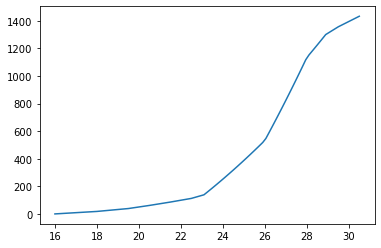

In [107]:
#plt.plot(ds_psi['sigma0'])
plt.plot(ds_psi['sigma0'], ds_psi['sigma0']* np.arange(0, len(ds_psi['sigma0']))**1)